In [2]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import pathlib
import numpy as np
import networkx
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString
import ee
import geemap

In [3]:
#ee.Authenticate()

In [4]:
#ee.Initialize()

# Storm Forecasts & Track
Storm forecasts and historical track will be published for each in-game day.

The forecasts represent model predictions for where the hurricane might be at the given timestamp.

The storm track represents the true path that the storm took in the past.

In [5]:
# Forecasts
link = 'https://files.bwsi-remote-sensing.net/data/final_2024/day3/day3_forecasts_2024.geojson'
day1_forecast = gpd.read_file(link)


In [6]:
day1_forecast

,prediction,forecastHour,datetime,maxWinds,category,geometry
0,1,12,2023-08-05 08:00:00,95,2,POINT (-71.4427 42.35526)
1,1,24,2023-08-05 20:00:00,90,2,POINT (-70.9599 43.29834)
2,1,36,2023-08-06 08:00:00,70,1,POINT (-70.13339 43.85976)
3,1,48,2023-08-06 20:00:00,65,1,POINT (-68.53599 43.32475)
4,1,60,2023-08-07 08:00:00,55,0,POINT (-68.0575 43.94382)
...,...,...,...,...,...,...
115,20,24,2023-08-05 20:00:00,90,2,POINT (-70.93159 43.32967)
116,20,36,2023-08-06 08:00:00,70,1,POINT (-70.29009 43.66332)
117,20,48,2023-08-06 20:00:00,65,1,POINT (-69.37494 44.56669)
118,20,60,2023-08-07 08:00:00,55,0,POINT (-68.60862 43.28433)


In [7]:
random_color = lambda: np.random.random(3)

/tmp/ipykernel_108/2735073594.py:32: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


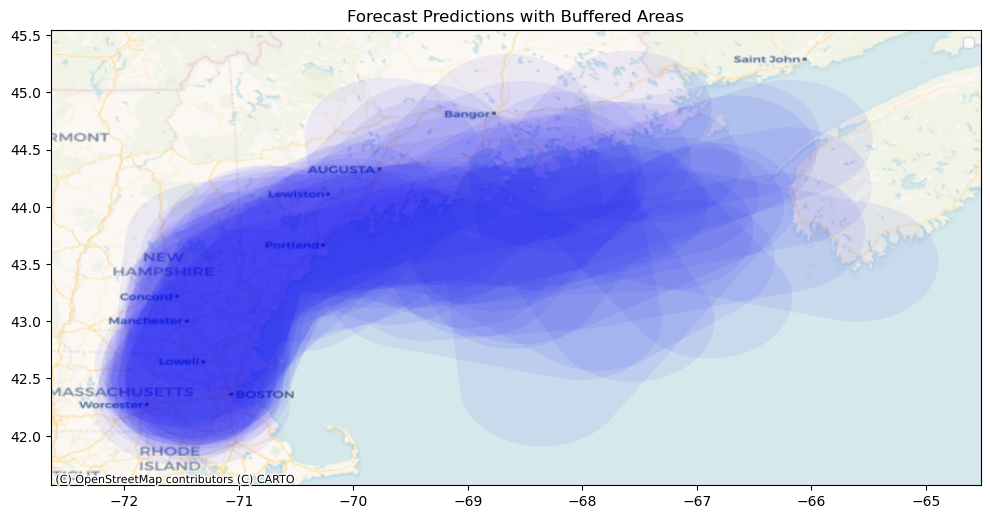

In [8]:
link = 'https://files.bwsi-remote-sensing.net/data/final_2024/day3/day3_forecasts_2024.geojson'
day1_forecast = gpd.read_file(link)

grouped = day1_forecast.groupby('prediction')

lines = []

for prediction_id, group in grouped:
    sorted_group = group.sort_values(by='forecastHour')
    points = sorted_group[sorted_group.geometry.type == 'Point']
    coords = [(geom.x, geom.y) for geom in points['geometry']]
    if len(coords) > 1:
        line = LineString(coords)
        lines.append({'prediction_id': prediction_id, 'geometry': line})

lines_gdf = gpd.GeoDataFrame(lines, geometry='geometry', crs=day1_forecast.crs)


fig, ax = plt.subplots(figsize=(12, 10))

lines_gdf = lines_gdf.to_crs(epsg=3857)

lines_gdf['geometry'] = lines_gdf.geometry.buffer(80000)  # Adjust the buffer size as needed

lines_gdf = lines_gdf.to_crs(epsg=4326)

lines_gdf.plot(ax=ax, edgecolor=None, facecolor='blue', alpha=0.06, label='Buffered Areas')

ctx.add_basemap(ax, crs=lines_gdf.crs.to_string(), source=ctx.providers.CartoDB.Voyager)

ax.set_title('Forecast Predictions with Buffered Areas')
ax.legend()
plt.show()


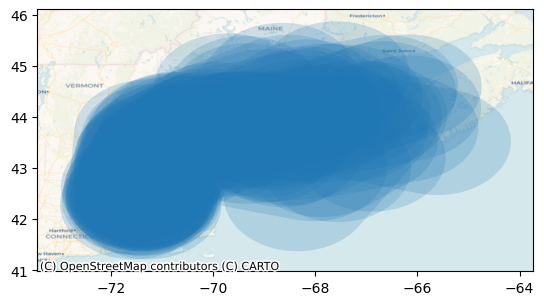

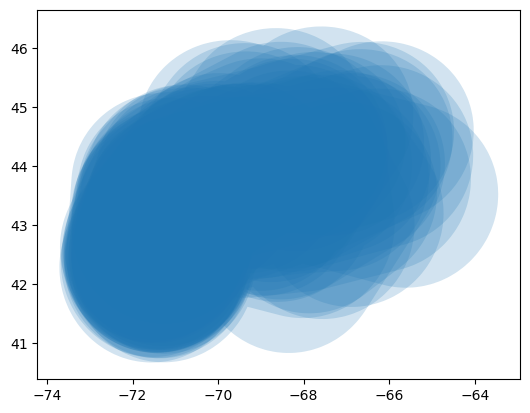

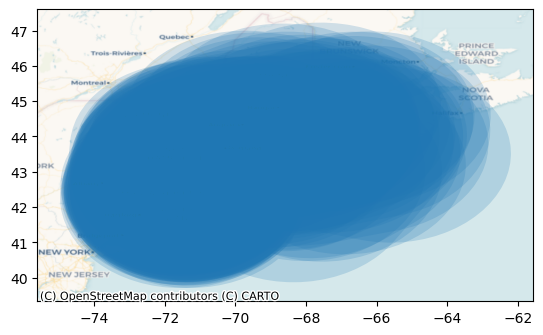

In [9]:
daily_forecast = lines_gdf.to_crs(epsg=3857).copy() 
daily_forecast['geometry'] = daily_forecast.geometry.buffer(80 * 1000) # Change to radius for specific wind speed
daily_forecast = daily_forecast.to_crs(epsg=4326) 

daily_forecast2 = lines_gdf.to_crs(epsg=3857).copy() 
daily_forecast2['geometry'] = daily_forecast2.geometry.buffer(160 * 1000) # Change to radius for specific wind speed
daily_forecast2 = daily_forecast2.to_crs(epsg=4326) 

daily_forecast3 = lines_gdf.to_crs(epsg=3857).copy()  
daily_forecast3['geometry'] = daily_forecast3.geometry.buffer(300 * 1000) # Change to radius for specific wind speed
daily_forecast3 = daily_forecast3.to_crs(epsg=4326) 


ax = daily_forecast.plot(edgecolor=None, label='Buffered Areas', alpha=0.2)
ctx.add_basemap(ax, crs=daily_forecast.crs, source = ctx.providers.CartoDB.Voyager)

ax2 = daily_forecast2.plot(edgecolor=None, label='Buffered Areas', alpha=0.2)
ctx.add_basemap(ax, crs=daily_forecast2.crs, source = ctx.providers.CartoDB.Voyager)

ax = daily_forecast3.plot(edgecolor=None, label='Buffered Areas', alpha=0.2)
ctx.add_basemap(ax, crs=daily_forecast3.crs, source = ctx.providers.CartoDB.Voyager)

/tmp/ipykernel_108/84441149.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounds = gdf.geometry.exterior.unary_union
/tmp/ipykernel_108/84441149.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounds = gdf.geometry.exterior.unary_union
/tmp/ipykernel_108/84441149.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounds = gdf.geometry.exterior.unary_union


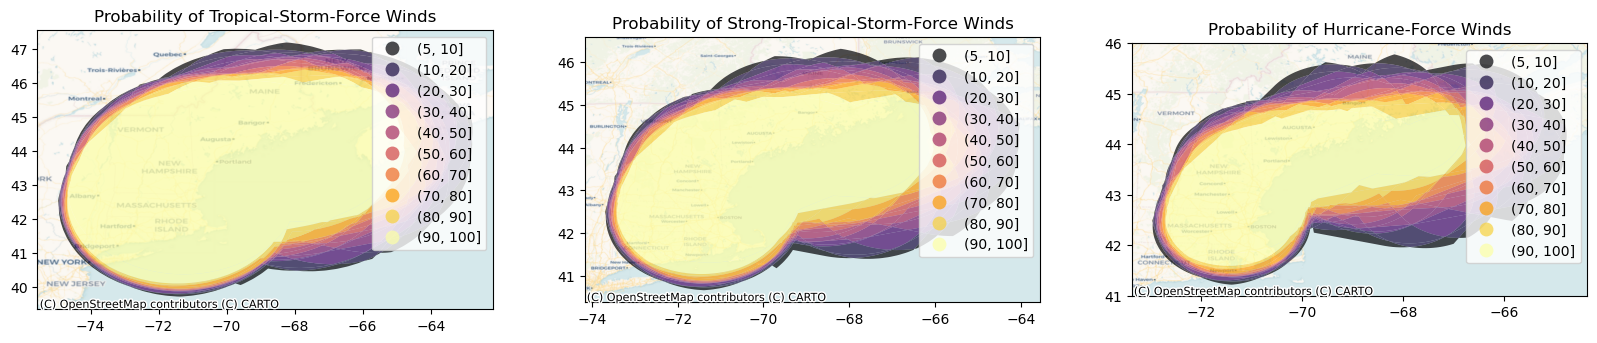

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
def count_overlapping_features(gdf):
    #generating all of the split pieces
    import shapely
    bounds = gdf.geometry.exterior.unary_union
    new_polys = list(shapely.ops.polygonize(bounds))
    new_gdf = gpd.GeoDataFrame(geometry=new_polys, crs=gdf.crs)
    new_gdf['id'] = range(len(new_gdf))

    #count overlapping by sjoin between pieces representative point (point inside polygon) and the input gdf 
    new_gdf_centroid = new_gdf.copy()
    new_gdf_centroid['geometry'] = new_gdf.geometry.representative_point()
    overlapcount = gpd.sjoin(new_gdf_centroid,gdf)
    overlapcount = overlapcount.groupby(['id'])['index_right'].count().rename('count').reset_index()
    out_gdf = pd.merge(new_gdf,overlapcount)
    return out_gdf

bin_edges = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
axes = [ax1, ax2, ax3]
categories = [daily_forecast3, daily_forecast2, daily_forecast]
titles = ['Probability of Tropical-Storm-Force Winds', 'Probability of Strong-Tropical-Storm-Force Winds', 'Probability of Hurricane-Force Winds']
for i in range(3):   
    overlaps = count_overlapping_features(categories[i])
    overlaps['prob'] = overlaps['count']/20
    overlaps['bin'] = pd.cut(overlaps['prob'] * 100, bins=bin_edges)

    axes[i].set_title(titles[i])
    overlaps.plot(column = 'bin', ax=axes[i], alpha = 0.7, legend=True, cmap = 'inferno')
    ctx.add_basemap(ax = axes[i], crs=overlaps.crs, source = ctx.providers.CartoDB.Voyager)

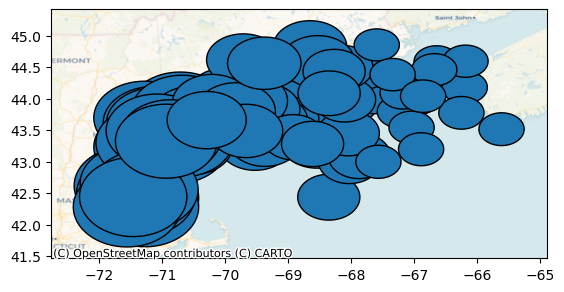

In [11]:
# each forecast report has a number of possible hurricane routes
# they are identified by the prediction column

#fig, ax = plt.subplots(1, 1, figsize=(10,10))
day1_forecast = day1_forecast.to_crs(epsg=3857) 
day1_forecast['geometry'] = day1_forecast.geometry.buffer(day1_forecast['maxWinds'] * 1000) #Run Only ONCE
day1_forecast = day1_forecast.to_crs(epsg=4326) 


ax = day1_forecast.plot(edgecolor='k', label='Buffered Areas')
ctx.add_basemap(ax, crs=day1_forecast.crs, source = ctx.providers.CartoDB.Voyager)
#plt.show()
#fig, ax = plt.subplots(1, 1, figsize=(10,10))
# for pred_id, pred in day1_forecast.groupby('prediction'):
#     print(pred)
#     #c = random_color()
#     #pred.plot(color=c, ax=ax)
#     #line_to_plot = LineString(pred.geometry.values)
#     #ax.plot(line_to_plot.xy[0], line_to_plot.xy[1], color=c, label=f'{pred_id}')
# ax.legend(title='prediction id')
#day1_forecast.plot(ax=ax, color='red', alpha=0.5, edgecolor='k', label='Buffered Areas')


In [12]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

# category1 = day2_forecast[day2_forecast['maxWinds'] >= 39]
# category2 = day2_forecast[day2_forecast['maxWinds'] >= 58]
# category3 = day2_forecast[day2_forecast['maxWinds'] >= 74]

# categories = [category1, category2, category3]
# axes = [ax1, ax2, ax3]
# buffers = [300, 160, 80]

# for i in range(3):
#     categories[i] = categories[i].to_crs(epsg=3857) 
#     categories[i]['geometry'] = categories[i].geometry.buffer(buffers[i] * 1000) #Run Only ONCE
#     categories[i] = categories[i].to_crs(epsg=4326) 

#     categories[i].plot(ax = axes[i], label='Buffered Areas')
#     ctx.add_basemap(axes[i], crs=categories[i].crs, source = ctx.providers.CartoDB.Voyager)



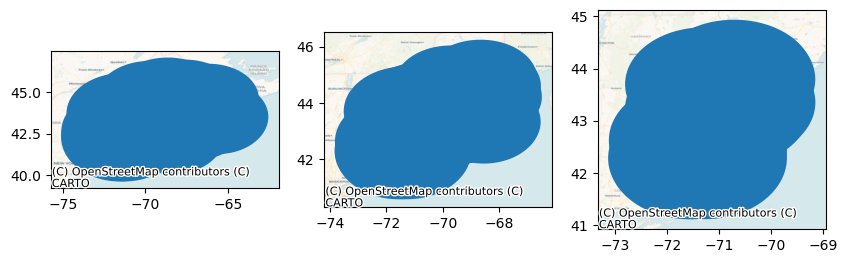

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

category1 = day1_forecast[day1_forecast['maxWinds'] >= 39]
category2 = day1_forecast[day1_forecast['maxWinds'] >= 58]
category3 = day1_forecast[day1_forecast['maxWinds'] >= 74]


category1 = category1.to_crs(epsg=3857) 
category1['geometry'] = category1.geometry.buffer(300 * 1000) #Run Only ONCE
category1 = category1.to_crs(epsg=4326) 

category1.plot(ax = ax1, label='Buffered Areas')
ctx.add_basemap(ax1, crs=category1.crs, source = ctx.providers.CartoDB.Voyager)


category2 = category2.to_crs(epsg=3857) 
category2['geometry'] = category2.geometry.buffer(160 * 1000) #Run Only ONCE
category2 = category2.to_crs(epsg=4326) 

category2.plot(ax = ax2, label='Buffered Areas')
ctx.add_basemap(ax2, crs=category2.crs, source = ctx.providers.CartoDB.Voyager)


category3 = category3.to_crs(epsg=3857) 
category3['geometry'] = category3.geometry.buffer(80 * 1000) #Run Only ONCE
category3 = category3.to_crs(epsg=4326) 

category3.plot(ax = ax3, label='Buffered Areas')
ctx.add_basemap(ax3, crs=category3.crs, source = ctx.providers.CartoDB.Voyager)

In [14]:
# def visualizeUncertainty(all_forecasts):
#     forecasts_list = all_forecasts['geometry']

#     merged = forecasts_list[0].union(forecasts_list[1]).convex_hull

#     for i in range(1, len(forecasts_list)-1): #iterates over polygons
#         next = forecasts_list[i].union(forecasts_list[i+1]).convex_hull
#         merged = merged.union(next)


#     return merged

/tmp/ipykernel_108/3818660046.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounds = gdf.geometry.exterior.unary_union
/tmp/ipykernel_108/3818660046.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounds = gdf.geometry.exterior.unary_union
/tmp/ipykernel_108/3818660046.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounds = gdf.geometry.exterior.unary_union


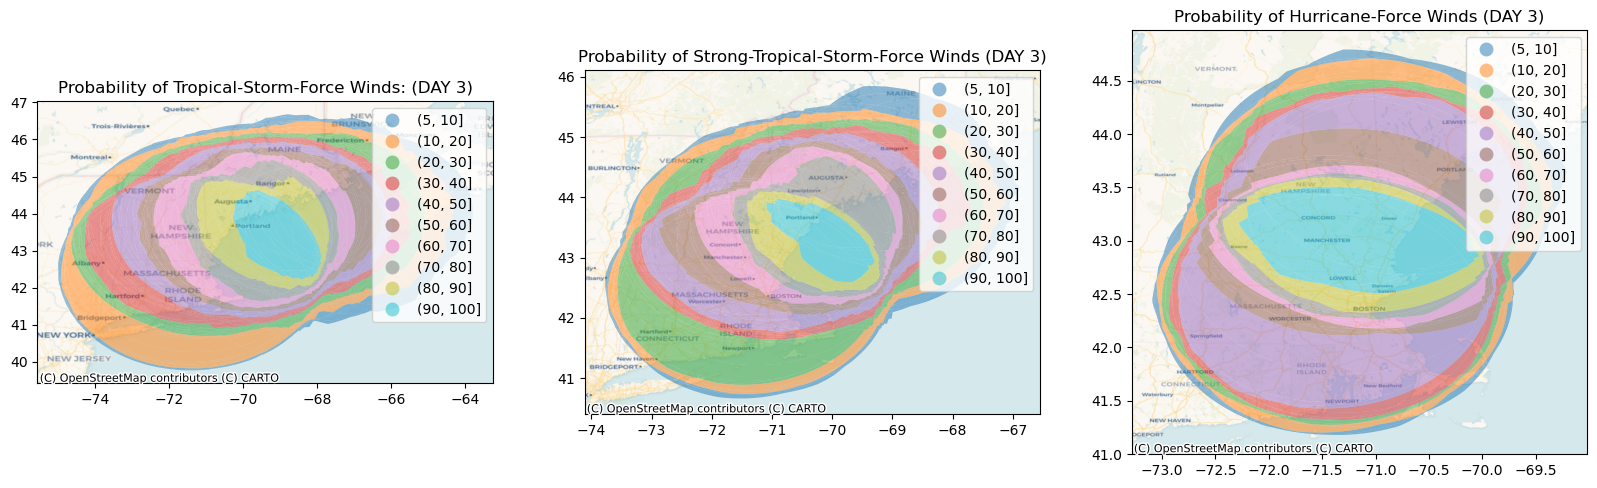

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
def count_overlapping_features(gdf):
    #generating all of the split pieces
    import shapely
    bounds = gdf.geometry.exterior.unary_union
    new_polys = list(shapely.ops.polygonize(bounds))
    new_gdf = gpd.GeoDataFrame(geometry=new_polys, crs=gdf.crs)
    new_gdf['id'] = range(len(new_gdf))

    #count overlapping by sjoin between pieces representative point (point inside polygon) and the input gdf 
    new_gdf_centroid = new_gdf.copy()
    new_gdf_centroid['geometry'] = new_gdf.geometry.representative_point()
    overlapcount = gpd.sjoin(new_gdf_centroid,gdf)
    overlapcount = overlapcount.groupby(['id'])['index_right'].count().rename('count').reset_index()
    out_gdf = pd.merge(new_gdf,overlapcount)
    return out_gdf

bin_edges = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
axes = [ax1, ax2, ax3]
categories = [category1, category2, category3]
titles = ['Probability of Tropical-Storm-Force Winds: (DAY 3)', 'Probability of Strong-Tropical-Storm-Force Winds (DAY 3)', 'Probability of Hurricane-Force Winds (DAY 3)']

for i in range(3):   
    overlaps = count_overlapping_features(categories[i])
    overlaps['prob'] = overlaps['count']/len(categories[i]['geometry'])

    overlaps['bin'] = pd.cut(overlaps['prob'] * 100, bins=bin_edges)

    axes[i].set_title(titles[i])
    overlaps.plot(column = 'bin', ax=axes[i], alpha=0.5, legend=True)
    ctx.add_basemap(ax = axes[i], crs=overlaps.crs, source = ctx.providers.CartoDB.Voyager)

In [16]:
# track shows where the storm actually went in the past
link2 = 'https://files.bwsi-remote-sensing.net/data/final_2024/day1/day1_track_past.geojson'
day1_track = gpd.read_file(link2)
day1_track

,geometry
0,"LINESTRING (-69.4 37.7, -69.8 38)"


In [17]:
day1_grouped= day1_grouped.groupby('datetime')
day1_grouped

NameError: name 'day1_grouped' is not defined

In [ ]:
# each forecast report has a number of possible hurricane routes
# they are identified by the prediction column
fig, ax = plt.subplots(1, 1, figsize=(10,10))


for datetime, point in day1_grouped:
    point = point.to_crs(epsg=3857)
    centroid = point.dissolve().centroid.to_crs(epsg=4326)#.values[0]
    centroid = centroid.values[0]
    print(centroid)
    print(distances)
    ax.plot(centroid.x, centroid.y, 'ro', label=f'{pred_id}', markersize=8)
ctx.add_basemap(ax, crs=day1_forecast.crs, source = ctx.providers.CartoDB.Voyager)

# Location of Areas of Interest


In [ ]:
#put it in meters
day1_forecast_utm = (day1_forecast
                     .to_crs(day1_forecast.estimate_utm_crs())
                    )

day1_forecast_utm["x"] = day1_forecast_utm.geometry.x
day1_forecast_utm["y"] = day1_forecast_utm.geometry.y

day1_forecast_utm
#centroids
day1_forecast_centroid_utm = (day1_forecast_utm
     .groupby('forecastHour', as_index=False)
     [['x','y']]
     .mean()
     .assign(geometry = lambda df : gpd.points_from_xy(x=df.x,y=df.y, crs=day1_forecast_utm.crs ))
    )


day1_forecast_centroid_utm

dist_gdf = (day1_forecast_utm
 .merge(day1_forecast_centroid_utm[['forecastHour','geometry']], how='left', on='forecastHour', suffixes=['_orig', '_cent'])
 .assign(dist_m = lambda df: df.geometry_orig.distance(df.geometry_cent))
)

dist_gdf

#distances between points and centroids
dist_gdf = (day1_forecast_utm
 .merge(day1_forecast_centroid_utm[['forecastHour','geometry']], how='left', on='forecastHour', suffixes=['_orig', '_cent'])
 .assign(dist_m = lambda df: df.geometry_orig.distance(df.geometry_cent))
)

dist_gdf

radii = dist_gdf.groupby("forecastHour", as_index=False)[["dist_m"]].mean()
radii

#.pipe switches the grouped dataframe to a geodataframe
day1_forecast_dist_m_utm = (day1_forecast_centroid_utm.merge(radii, on="forecastHour")
                           .pipe(gpd.GeoDataFrame))
day1_forecast_dist_m_utm

#makes points into circles
day1_forecast_circle  = day1_forecast_dist_m_utm
day1_forecast_circle['geometry'] = day1_forecast_circle.geometry.buffer(day1_forecast_circle.dist_m)
day1_forecast_circle
def visualizeUncertainty(all_forecasts):
    forecasts_list = all_forecasts['geometry']

    merged = forecasts_list[0].union(forecasts_list[1]).convex_hull

    for i in range(1, len(forecasts_list)-1): #iterates over polygons
        next = forecasts_list[i].union(forecasts_list[i+1]).convex_hull
        merged = merged.union(next)


    return merged

# Convert to a GeoDataFrame
cone_of_uncertainty = gpd.GeoDataFrame(geometry=[visualizeUncertainty(day1_forecast_circle)], crs=day1_forecast_circle.crs)

fig, ax = plt.subplots(1, 1, figsize=(10,10))

cone_of_uncertainty.plot(ax=ax, alpha=0.5)

ctx.add_basemap(ax,
               crs=day1_forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )